## Quickstart

In this section, users will learn

1. the data input required to create a basic MMM
2. the fit and predict process of MMM
2. basic usage of the MMM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option("display.float_format", lambda x: "%.3f" % x)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

In [3]:
RAW_DATA_FILE = "resource/seasonal/df.csv"
SCALABILITY_FILE = "resource/seasonal/scalability_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
df.head(5)

,date,sales,promo,radio,search,social,tv,new-years-day,martin-luther-king-jr-day,washingtons-birthday,...,labor-day,columbus-day,veterans-day,thanksgiving,christmas-day,independence-day-observed,juneteenth-national-independence-day-observed,juneteenth-national-independence-day,christmas-day-observed,new-years-day-observed
0,2019-01-01,631.000,1070.000,7319.000,0.000,2530.000,8755.000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-02,397.000,1926.000,5729.000,4189.000,1635.000,5621.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-03,530.000,2224.000,0.000,4820.000,0.000,13586.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-04,766.000,2405.000,3163.000,0.000,0.000,10953.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-05,1168.000,2122.000,8359.000,2937.000,0.000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note that the one-hot-encoded dummies are already appended in the dataframe. To use them, users need to supply the list of the events to the model.

In [5]:
event_cols = [
    "new-years-day",
    "martin-luther-king-jr-day",
    "washingtons-birthday",
    "memorial-day",
    "independence-day",
    "labor-day",
    "columbus-day",
    "veterans-day",
    "thanksgiving",
    "christmas-day",
    "independence-day-observed",
    "juneteenth-national-independence-day-observed",
    "juneteenth-national-independence-day",
    "christmas-day-observed",
    "new-years-day-observed",
]

The `scalability_df` is used to determine a normalizer of a channel with respect to its spend volume.

In [6]:
scalability_df = pd.read_csv(SCALABILITY_FILE)
scalability_df.head(5)

,regressor,scalability
0,promo,3.000
1,radio,1.250
2,search,0.800
3,social,1.300
4,tv,1.500


### Fitting a Basic MMM

In [7]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=event_cols,
    seed=2022,
    seasonality=[7, 365.25],
    fs_orders=[2, 3],
    events_sigma_prior=0.3,
)

2023-12-10 14:40:50 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.00245,
}
mmm.set_hyper_params(best_params)

2023-12-10 14:40:50 - karpiu-mmm - INFO - Set hyper-parameters.
2023-12-10 14:40:50 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-12-10 14:40:50 - karpiu-mmm - INFO - Best params level_sm_input set as 0.00245


Fit the model with supplied dataframe.

<div class="alert alert-block alert-success"> <b>Tips:</b> Users can provide additional arg e.g. `chains=4` to perform sampling with multiple chains. </div>

In [9]:
mmm.fit(df, num_warmup=1000, num_sample=1000)

2023-12-10 14:40:50 - karpiu-mmm - INFO - Fit final model.
2023-12-10 14:40:50 - karpiu-mmm - INFO - Deriving saturation constants...
2023-12-10 14:40:50 - karpiu-mmm - INFO - Derived saturation constants.
2023-12-10 14:40:50 - karpiu-mmm - INFO - Build a default regression scheme
2023-12-10 14:40:50 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 1000.


chain 1 |          | 00:00 Status

2023-12-10 14:43:50 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.44208885) is within common range (0, 0.8].


## Extracting Insights from the Model

### Attribution

In [10]:
from karpiu.explainability import AttributorGamma

In [11]:
ATTR_START = "2019-03-01"
ATTR_END = "2019-03-31"
attributor = AttributorGamma(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

2023-12-10 14:43:50 - karpiu-planning - INFO - Full calculation start=2019-03-01 and end=2019-03-31
2023-12-10 14:43:50 - karpiu-planning - INFO - Attribution start=2019-03-01 and end=2019-03-31


In [12]:
from karpiu.plots import (
    plot_attribution_with_time,
    plot_attribution_waterfall,
    ColorConstants,
)

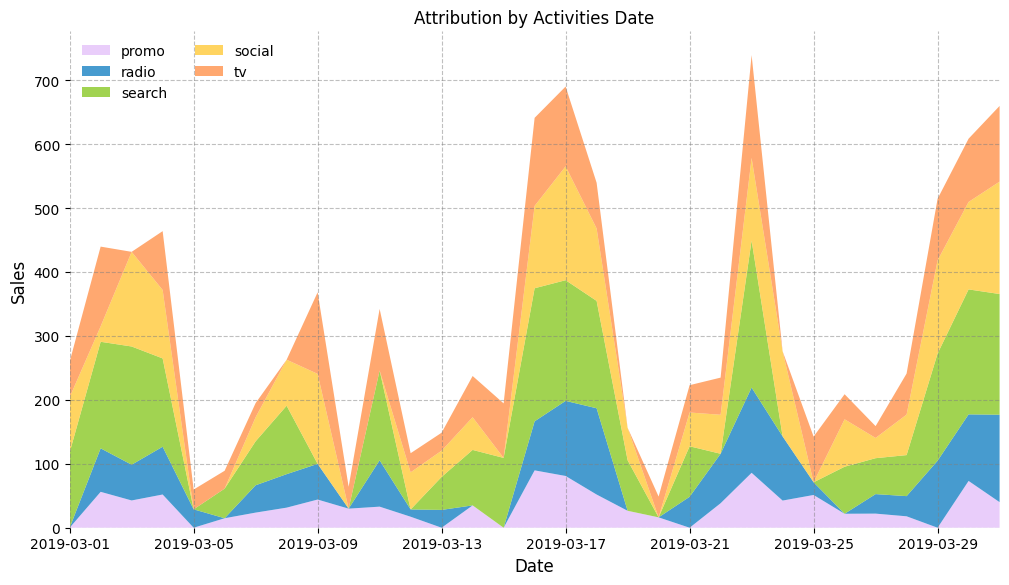

In [13]:
ax = plot_attribution_with_time(
    model=mmm,
    attr_df=activities_attr_df,
    figsize=(10, 5.5),
    colors=ColorConstants.RAINBOW_SIX,
    show=False,
    dt_col="date",
    include_organic=False,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 12})
ax.set_xlabel("Date", fontdict={"fontsize": 12})
ax.set_ylabel("Sales", fontdict={"fontsize": 12})

fig = ax.figure
fig

Users can also compare sales composition aggregated by channels.

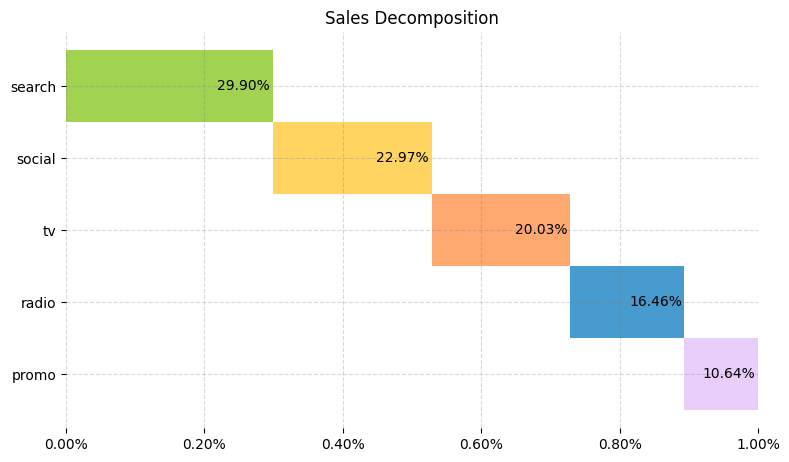

In [14]:
ax = plot_attribution_waterfall(
    model=mmm,
    attr_df=spend_attr_df,
    figsize=(8, 4.5),
    include_organic=False,
    colors=ColorConstants.RAINBOW_SIX,
    show=False,
)
ax.set_title("Sales Decomposition", fontdict={"fontsize": 12})
fig = ax.figure
fig

### Cost and Efficiency Analysis

In [15]:
from karpiu.planning.cost_curves import CostCurves

In [16]:
cc = CostCurves(
    model=mmm,
    curve_type="individual",
    n_steps=50,
    spend_start=ATTR_START,
    spend_end=ATTR_END,
)
cc.generate_cost_curves()

2023-12-10 14:43:51 - karpiu-planning - INFO - Minimum spend threshold is hit in some channel(s). Update with value 0.001.
2023-12-10 14:43:51 - karpiu-planning - INFO - Derived channels multipliers based on input spend.


  0%|          | 0/5 [00:00<?, ?it/s]

To prevent overflow, users can provide a scaler in plotting the cost curves.

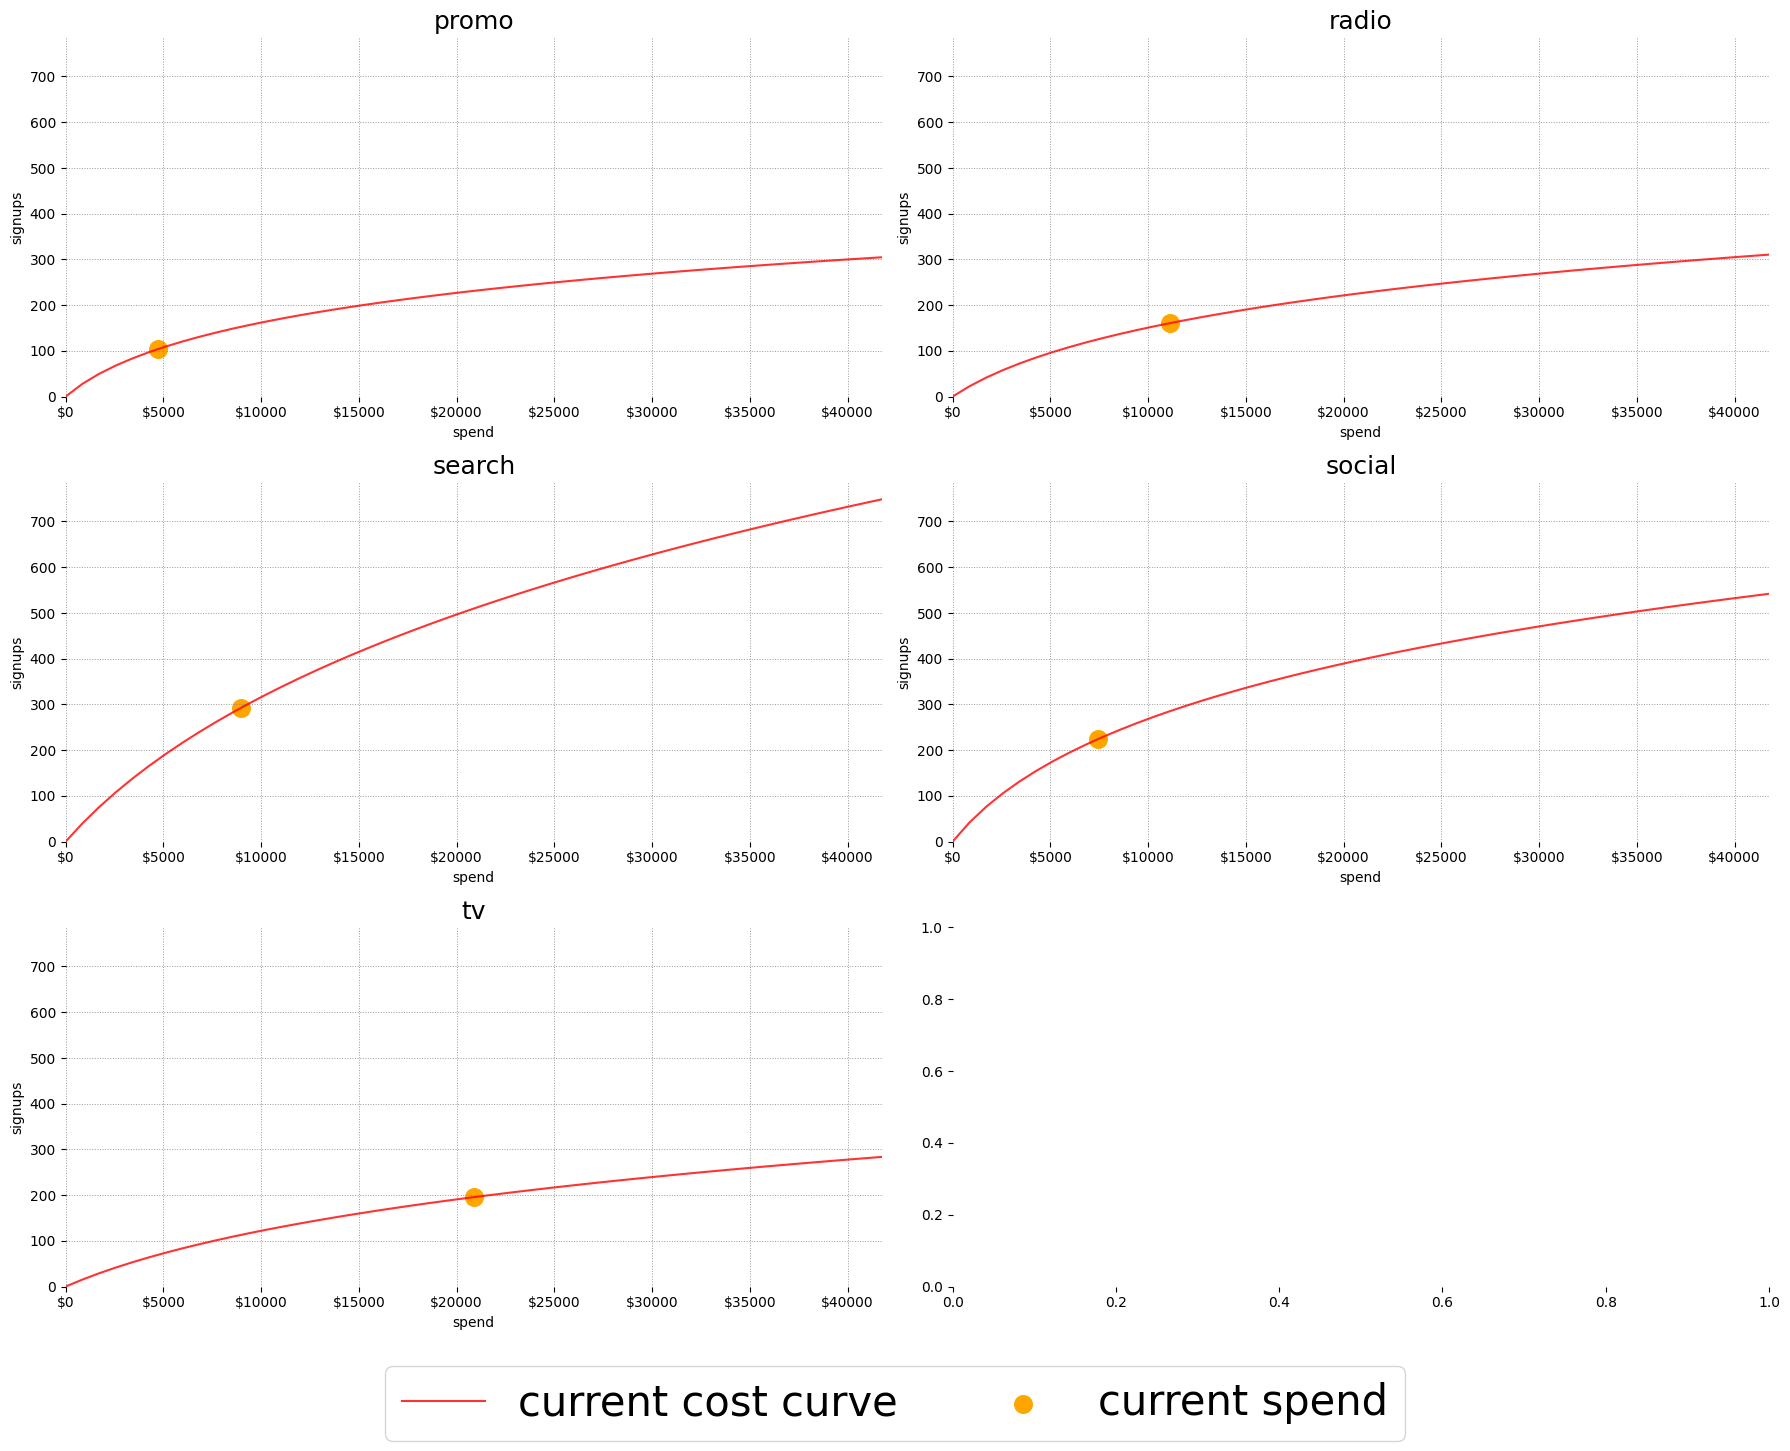

In [17]:
cc.plot(spend_scaler=10, outcome_scaler=10, include_organic=False);

### Model Regression Coefficents

In [18]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.046,0.040,0.052,1.000,0.000,0.000,0.100
1,radio,Positive,0.061,0.056,0.065,1.000,0.000,0.000,0.100
2,search,Positive,0.174,0.167,0.182,1.000,0.000,0.000,0.100
3,social,Positive,0.094,0.089,0.100,1.000,0.000,0.000,0.100
4,tv,Positive,0.067,0.062,0.072,1.000,0.000,0.000,0.100
5,s7_fs_cos1,Regular,0.181,0.178,0.185,1.000,0.000,0.000,0.300
6,s7_fs_cos2,Regular,0.102,0.098,0.105,1.000,0.000,0.000,0.300
7,s7_fs_sin1,Regular,-0.626,-0.630,-0.622,0.000,1.000,0.000,0.300
8,s7_fs_sin2,Regular,0.006,0.003,0.009,0.995,0.005,0.000,0.300
9,s365.25_fs_cos1,Regular,-0.100,-0.107,-0.093,0.000,1.000,0.000,0.300


## Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version. Here a demo of using `insert_event` and `extend_ts_features` are also shown to generate future dataframe for long-term forecast checking.

In [19]:
from karpiu.utils import insert_events, extend_ts_features
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [20]:
future_df = extend_ts_features(df, 365, date_col="date")
future_df, event_cols = insert_events(future_df, date_col="date", country="US")

In [21]:
pred_df = mmm.predict(future_df)

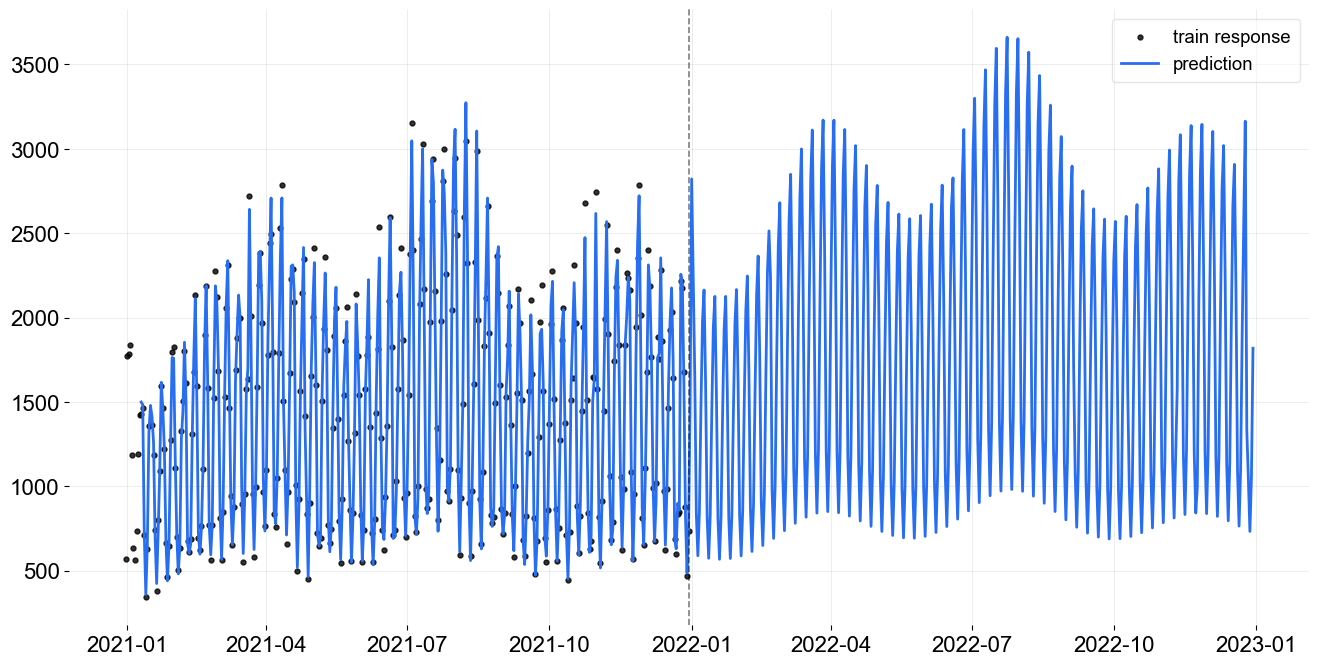

In [22]:
plot_predicted_data(
    training_actual_df=df[-365:],
    predicted_df=pred_df[-(720):],
    date_col="date",
    actual_col="sales",
);

In [23]:
pred_df = mmm.predict(future_df, decompose=True)

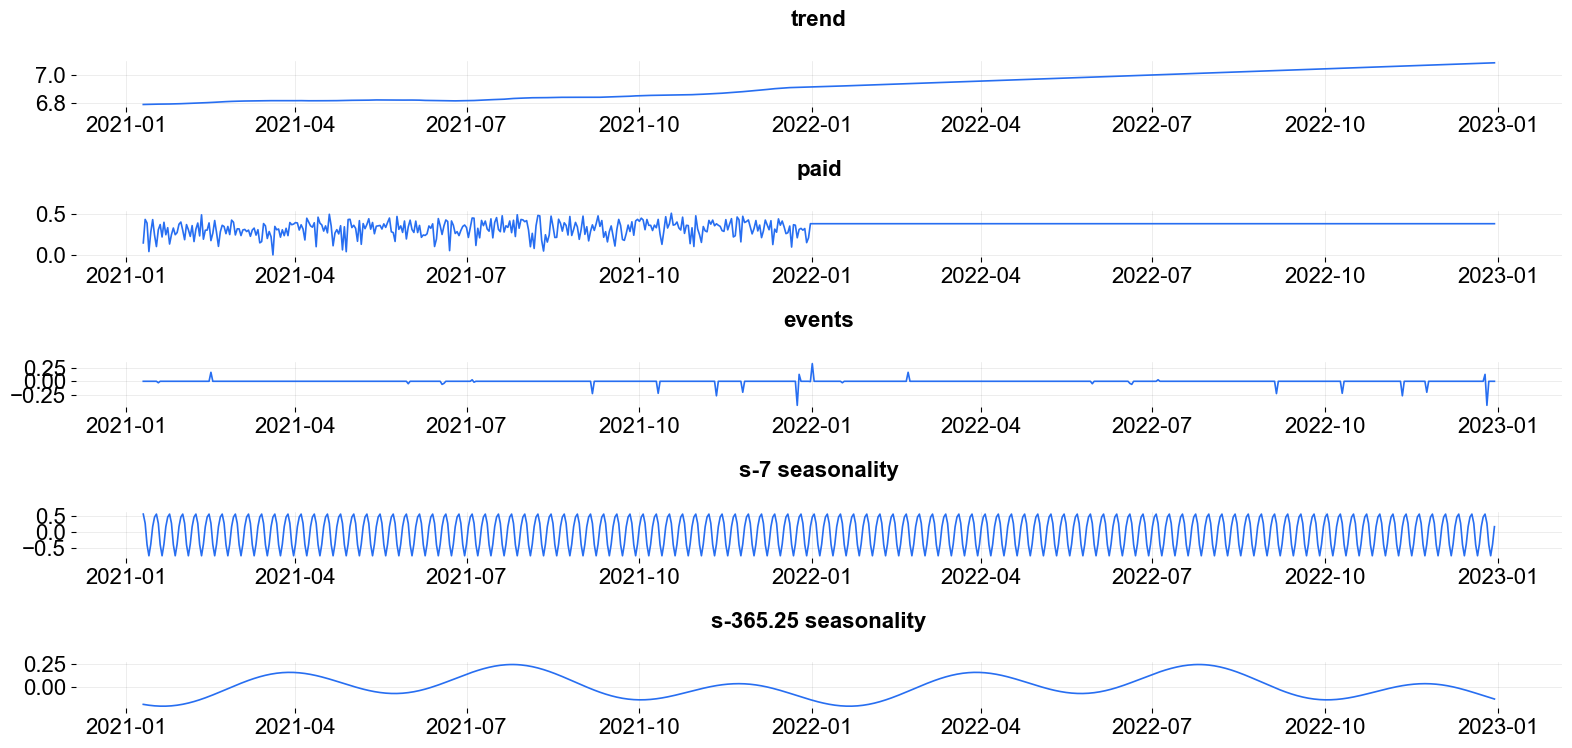

In [24]:
plot_predicted_components(
    predicted_df=pred_df[-720:],
    date_col="date",
    plot_components=[
        "trend",
        "paid",
        "events",
        "s-7 seasonality",
        "s-365.25 seasonality",
    ],
);

## Dump Model for Future Usage

In [25]:
import pickle

with open("./resource/seasonal/model.pkl", "wb") as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)